Importing libraries

In [45]:
import numpy as np
from nltk.tokenize import RegexpTokenizer
from keras.models import Sequential, load_model
from keras.layers import LSTM
from keras.layers.core import Dense, Activation
from keras.optimizers import RMSprop
import matplotlib.pyplot as plt
import pickle
import heapq

Loading the data

In [46]:
path = "1661-0.txt"
f=open(path,"r",encoding='utf-8')
text_data = f.read().lower()
print("corpus length:", len(text_data))

corpus length: 581888


Splitting dataset without special characters

In [47]:
tokenizer = RegexpTokenizer(r'\w+')
words = tokenizer.tokenize(text_data)
print(words)

['project', 'gutenberg', 's', 'the', 'adventures', 'of', 'sherlock', 'holmes', 'by', 'arthur', 'conan', 'doyle', 'this', 'ebook', 'is', 'for', 'the', 'use', 'of', 'anyone', 'anywhere', 'at', 'no', 'cost', 'and', 'with', 'almost', 'no', 'restrictions', 'whatsoever', 'you', 'may', 'copy', 'it', 'give', 'it', 'away', 'or', 're', 'use', 'it', 'under', 'the', 'terms', 'of', 'the', 'project', 'gutenberg', 'license', 'included', 'with', 'this', 'ebook', 'or', 'online', 'at', 'www', 'gutenberg', 'net', 'title', 'the', 'adventures', 'of', 'sherlock', 'holmes', 'author', 'arthur', 'conan', 'doyle', 'release', 'date', 'november', '29', '2002', 'ebook', '1661', 'last', 'updated', 'may', '20', '2019', 'language', 'english', 'character', 'set', 'encoding', 'utf', '8', 'start', 'of', 'this', 'project', 'gutenberg', 'ebook', 'the', 'adventures', 'of', 'sherlock', 'holmes', 'produced', 'by', 'an', 'anonymous', 'project', 'gutenberg', 'volunteer', 'and', 'jose', 'menendez', 'cover', 'the', 'adventures',

In [48]:
unique_words = np.unique(words)
unique_word_index = dict((c, i) for i, c in enumerate(unique_words))

Feature Engineering

In [49]:
WORD_LENGTH = 5
prev_words = []
next_words = []
for i in range(len(words) - WORD_LENGTH):
    prev_words.append(words[i:i + WORD_LENGTH])
    next_words.append(words[i + WORD_LENGTH])
print(prev_words[0])
print(next_words[0])

['project', 'gutenberg', 's', 'the', 'adventures']
of


In [50]:
X = np.zeros((len(prev_words), WORD_LENGTH, len(unique_words)), dtype=bool)
Y = np.zeros((len(next_words), len(unique_words)), dtype=bool)
for i, each_words in enumerate(prev_words):
    for j, each_word in enumerate(each_words):
        X[i, j, unique_word_index[each_word]] = 1
    Y[i, unique_word_index[next_words[i]]] = 1

In [51]:
print(X[0][0])

[False False False ... False False False]


Recurrent Neural Network

In [52]:
model = Sequential()
model.add(LSTM(128, input_shape=(WORD_LENGTH, len(unique_words))))
model.add(Dense(len(unique_words)))
model.add(Activation('softmax'))

Training Model

In [53]:
optimizer = RMSprop(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
history = model.fit(X, Y, validation_split=0.05, batch_size=128, epochs=10, shuffle=True).history

C:\LGMVIP_DS_JAN\venv\lib\site-packages\keras\optimizers\optimizer_v2\rmsprop.py:143: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/10
811/811 [==============================] - 146s 177ms/step - loss: 6.0029 - accuracy: 0.1086 - val_loss: 7.0186 - val_accuracy: 0.1025
Epoch 2/10
811/811 [==============================] - 133s 164ms/step - loss: 5.7733 - accuracy: 0.1474 - val_loss: 7.8498 - val_accuracy: 0.1062
Epoch 3/10
811/811 [==============================] - 135s 167ms/step - loss: 5.7450 - accuracy: 0.1761 - val_loss: 8.0884 - val_accuracy: 0.1080
Epoch 4/10
811/811 [==============================] - 133s 165ms/step - loss: 5.4170 - accuracy: 0.2098 - val_loss: 8.2640 - val_accuracy: 0.1049
Epoch 5/10
811/811 [==============================] - 137s 169ms/step - loss: 5.0908 - accuracy: 0.2494 - val_loss: 8.4387 - val_accuracy: 0.0950
Epoch 6/10
811/811 [==============================] - 148s 183ms/step - loss: 4.7956 - accuracy: 0.2892 - val_loss: 8.6013 - val_accuracy: 0.0967
Epoch 7/10
811/811 [==============================] - 140s 173ms/step - loss: 4.5444 - accuracy: 0.3303 - val_loss: 8.9255 -

In [54]:
model.save('keras_next_word_model.h5')
pickle.dump(history, open("history.p", "wb"))
model = load_model('keras_next_word_model.h5')
history = pickle.load(open("history.p", "rb"))

Evaluating

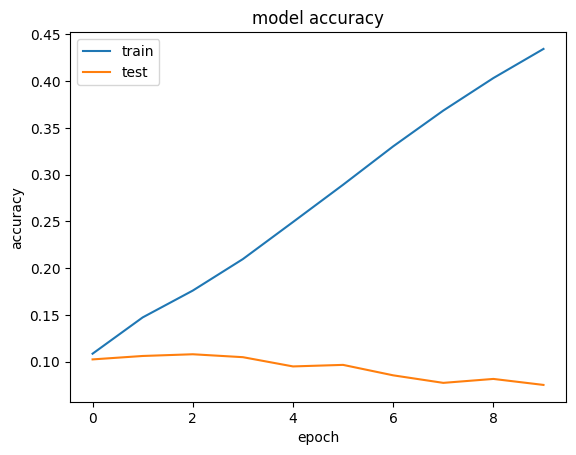

In [55]:
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

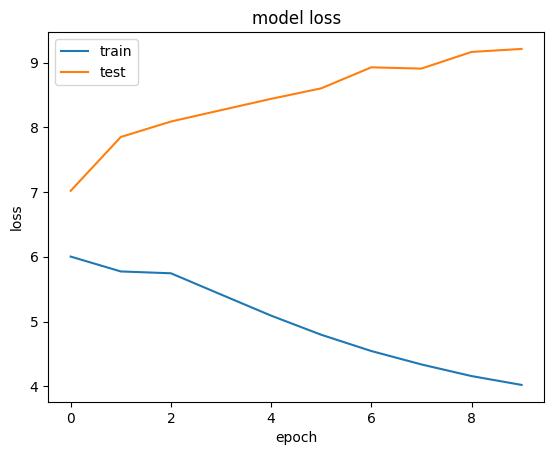

In [56]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

Testing the model

In [93]:
def prepare_input(text, SEQUENCE_LENGTH=None, chars=None, char_indices=None):
    x = np.zeros((1, SEQUENCE_LENGTH, len(chars)))
    for t, char in enumerate(text):
        x[0, t, char_indices[char]] = 1.

    return x

In [94]:
def prepare_input(text):
    x = np.zeros((1, WORD_LENGTH, len(unique_words)))
    for t, word in enumerate(text.split()):
        print(word)
        x[0, t, unique_word_index[word]] = 1
    return x
prepare_input("It is not a lack".lower())


it
is
not
a
lack


array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])

In [95]:
def sample(preds, top_n=3):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds)
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)

    return heapq.nlargest(top_n, range(len(preds)), preds.take)

In [96]:
def predict_completion(text, indices_char=None):
    original_text = text
    generated = text
    completion = ''
    while True:
        x = prepare_input(text)
        preds = model.predict(x, verbose=0)[0]
        next_index = sample(preds, top_n=1)[0]
        next_char = indices_char[next_index]
        text = text[1:] + next_char
        completion += next_char

        if len(original_text + completion) + 2 > len(original_text) and next_char == ' ':
            return completion

In [97]:
def predict_completions(text, n=3):
    if text == "":
        return("0")
    x = prepare_input(text)
    preds = model.predict(x, verbose=0)[0]
    next_indices = sample(preds, n)
    return [unique_words[idx] for idx in next_indices]

In [104]:
q =  "Suddenly there was the momentary gleam of light up in the direction of the ventilator, which vanished immediately, but"
seq = " ".join(tokenizer.tokenize(q.lower())[0:5])
print("Sequence: ",seq)
print("next possible words: ", predict_completions(seq, 5))

Sequence:  suddenly there was the momentary
suddenly
there
was
the
momentary
next possible words:  ['a', 'with', 'man', 'more', 'she']
